A Smart Stock and Crypto Pricing Notifer and Predictor 

Step 1: Install the necessary libraries

In [9]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
!pip install keras
!pip install pyttsx3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Step 2: Import the necessary libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
import pyttsx3


Step 3: Load and preprocess the data

In [11]:
# Load the data
df = pd.read_csv('TITAN.csv')

# Set the date column as the index
df = df.set_index('Date')

# Drop any rows with missing data
df = df.dropna()

# Get the close price column
close_data = df.filter(["Close"]).values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Split the data into training and testing datasets
training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


Step 4: Define the LSTM model

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")


Step 5: Train the LSTM model

In [13]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1905/1905 [==============================] - 65s 32ms/step - loss: 1.1511e-04


Step 6: Save the trained model

In [14]:
model.save('titan_lstm_model.h5')

Step 7: Load the trained model (if already trained)

In [15]:
model = load_model('titan_lstm_model.h5')


Step 8: Prepare the test data

In [16]:
# Get the test data
test_data = scaled_data[training_data_len - 60: , :]

# Split the test data into x_test and y_test datasets
x_test = []
y_test = close_data[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


Step 9: Make predictions using the trained model

16/16 [==============================] - 3s 34ms/step
RMSE: 22.06359917976706


<ipython-input-18-f21c1ef0ec1d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


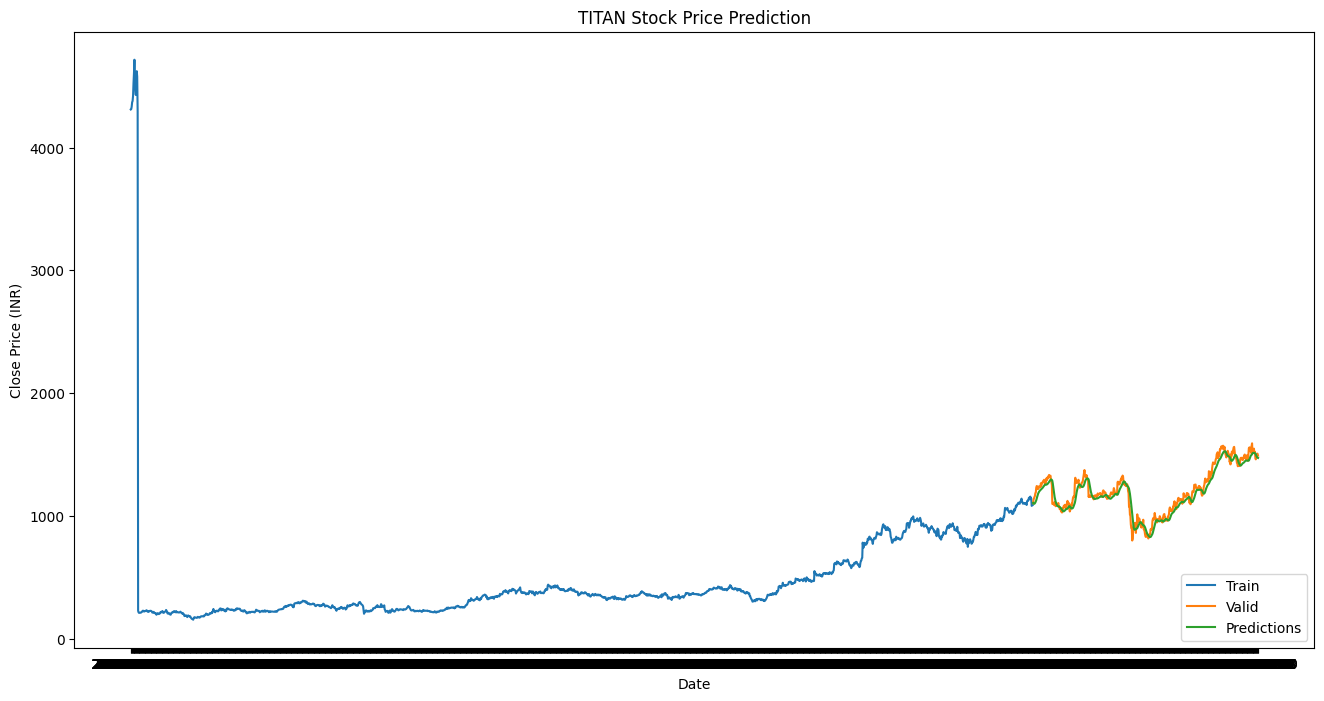

In [18]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:', rmse)

# Plot the data
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('TITAN Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()
